In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def normalizing(specs, min_val, max_val):
    return 2 * (specs - min_val) / (max_val - min_val) - 1

def denormalizing(norm_specs, min_val, max_val):
    return (norm_specs + 1) / 2 * (max_val - min_val) + min_val

In [4]:
base = 'TODO'

with h5py.File(f'/content/drive/MyDrive/Colab Notebooks/M2/A3net/sdss_galaxy_spec.hdf5', 'r') as fp :

    # redshift
    z = fp['raw']['z'][...]

    # physical properties
    ages = fp['raw']['age'][...]
    metallicity = fp['raw']['metallicity'][...]
    smass = fp['raw']['smass'][...]

    # spectra, including error bars
    wavelength = fp['raw']['wavelength'][...]
    specs = fp['raw']['spec'][...]
    specerrs = fp['raw']['specerr'][...]


# Normalizing specs
# smass[smass < 0] = 100000 #some smass values are <0, so it better to avoid use these values
# smass = np.log10(smass)
# specs = (specs - specs.min()) / (specs.max() - specs.min())
# metallicity = (metallicity - metallicity.min()) / (metallicity.max() - metallicity.min())

In [5]:


def smooth_spectrum(x, y, degree=6, num_points=500):
    """
    x: wavelength (1D array)
    y: intensity (1D array)
    degree: 多項式の次数
    num_points: 補間後の点の数
    """
    # 多項式特徴量
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(x.reshape(-1, 1))

    # 線形回帰でフィット
    model = LinearRegression()
    model.fit(X_poly, y)

    # スムーズな波長軸を作る
    x_smooth = np.linspace(x.min(), x.max(), num_points)
    X_smooth_poly = poly.transform(x_smooth.reshape(-1, 1))
    y_smooth = model.predict(X_smooth_poly)

    return x_smooth, y_smooth

In [6]:
specs_smoothed = []
for i in range(len(specs)):
    x_s, y_s = smooth_spectrum(wavelength[400:4000], specs[i][400:4000], degree=6, num_points=4000-400)
    specs_smoothed.append(y_s)
specs = np.array(specs_smoothed)

In [7]:
specs_norm = []
metallicity_norm = []
smass_norm = []
ages_norm = []
z_norm = []
for spec in specs:
    # spec = (spec-spec.min())/(spec.max()-spec.min())
    spec = normalizing(spec, spec.min(), spec.max())
    specs_norm.append(spec)
for m in metallicity:
    # m = (m-metallicity.min())/(metallicity.max()-metallicity.min())
    m = normalizing(m, metallicity.min(), metallicity.max())
    metallicity_norm.append(m)
for mass in smass:
    mass = normalizing(mass, smass.min(), smass.max())
    smass_norm.append(mass)
for age in ages:
    age = normalizing(age, ages.min(), ages.max())
    ages_norm.append(age)
for rs in z:
    rs = normalizing(rs, z.min(), z.max())
    z_norm.append(rs)
specs = np.array(specs_norm)
metallicity = np.array(metallicity_norm)
smass = np.array(smass_norm)
ages = np.array(ages_norm)
z = np.array(z_norm)

In [8]:
model = models.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(2048, activation='relu'),
    layers.Dense(2048, activation='relu'),
    layers.Dense(3600)
])


In [10]:
conditions = np.concatenate([metallicity.reshape(-1, 1), smass.reshape(-1, 1), ages.reshape(-1, 1), z.reshape(-1, 1)], axis=1)
conditions_test = conditions[9000:]
conditions = conditions[:9000]
specs_test = specs[9000:]
specs = specs[:9000]

In [11]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(conditions, specs, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.1839
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0928
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0759
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0742
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0722
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0697
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0732
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0651
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0685
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0720
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0694
Epoch 12/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0660
Epoch 13/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0666
Epoch 14/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0691
Epoch 15/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - l

In [12]:
# ランダムな条件からスペクトルを予測
# test_conditions = np.random.rand(5, cond_dim).astype(np.float32)
predicted_spectra = model.predict(conditions_test)




32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [13]:
predicted_spectra.shape

(1000, 3600)

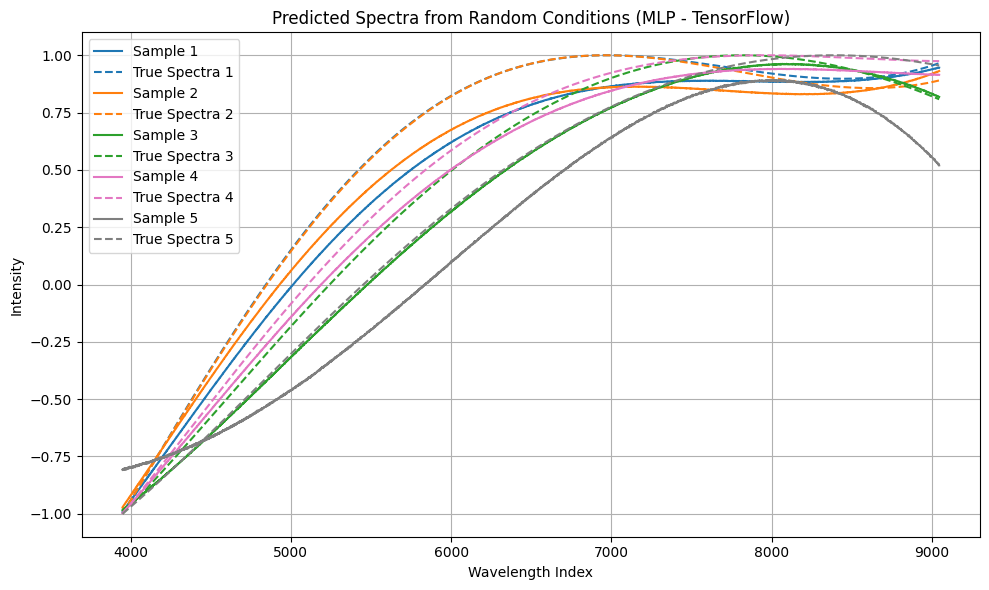

In [14]:
# プロット
ln_color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:gray']
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(wavelength[400:4000], predicted_spectra[i], label=f"Sample {i+1}", color=ln_color[i])
    plt.plot(wavelength[400:4000], specs_test[i], linestyle='--', label=f"True Spectra {i+1}", color=ln_color[i])
plt.title("Predicted Spectra from Random Conditions (MLP - TensorFlow)")
plt.xlabel("Wavelength Index")
plt.ylabel("Intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()